Epoch 1/10
150/150 [==============================] - 28s 177ms/step - loss: 1.7646 - _accuracy: 0.3560 - val_loss: 1.3661 - val__accuracy: 0.5369
Epoch 2/10
150/150 [==============================] - 17s 110ms/step - loss: 1.2064 - _accuracy: 0.5690 - val_loss: 1.0035 - val__accuracy: 0.6850
Epoch 3/10
150/150 [==============================] - 17s 113ms/step - loss: 0.9221 - _accuracy: 0.6754 - val_loss: 0.8261 - val__accuracy: 0.7312
Epoch 4/10
150/150 [==============================] - 19s 127ms/step - loss: 0.7571 - _accuracy: 0.7350 - val_loss: 0.7445 - val__accuracy: 0.7681
Epoch 5/10
150/150 [==============================] - 16s 110ms/step - loss: 0.6279 - _accuracy: 0.7740 - val_loss: 0.6808 - val__accuracy: 0.7887
Epoch 6/10
150/150 [==============================] - 17s 110ms/step - loss: 0.5652 - _accuracy: 0.8025 - val_loss: 0.6528 - val__accuracy: 0.7906
Epoch 7/10
150/150 [==============================] - 17s 116ms/step - loss: 0.4977 - _accuracy: 0.8233 - val_loss: 0.

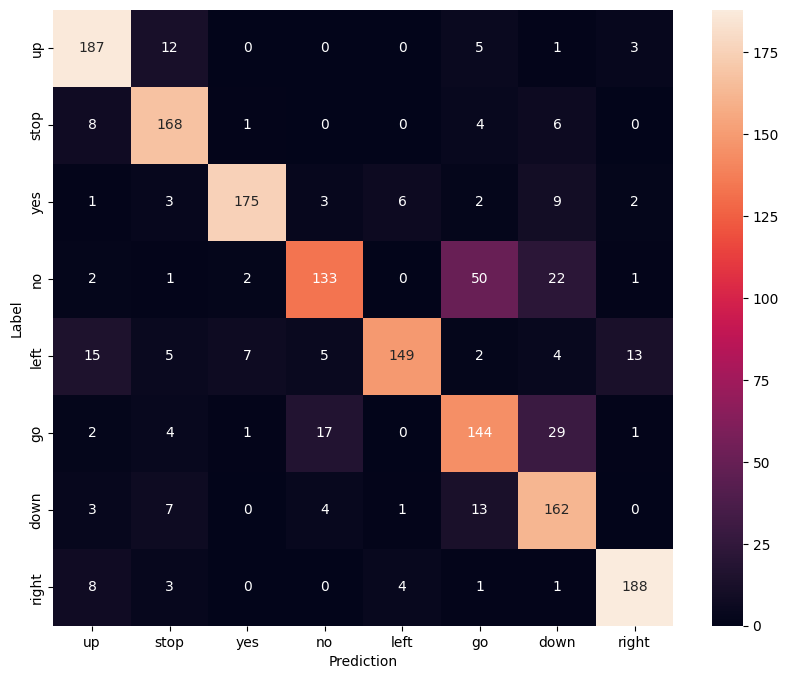

1/1 [==============================] - 0s 87ms/step
Prediction: ['yes' 'right' 'left' 'no' 'no']
Label: ['yes' 'right' 'left' 'down' 'no']


In [51]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models, Model
from IPython import display


class Network(Model):
  def __init__(self):
    super(Network, self).__init__()
    self.input_layer = layers.Input(shape=input_shape)
    self.resizing = layers.Resizing(32, 32)
    self.normalize = norm_layer
    self.conv1 = layers.Conv2D(32, 3, activation='relu')
    self.conv2 = layers.Conv2D(64, 3, activation='relu')
    self.pool = layers.MaxPooling2D()
    self.dropout1 = layers.Dropout(0.25)
    self.flatten = layers.Flatten()
    self.d1 = layers.Dense(128, activation='relu')
    self.dropout2 = layers.Dropout(0.5)
    self.d2 = layers.Dense(len(words))

  def call(self, x):
    x = self.resizing(x)
    x = self.normalize(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.pool(x)
    x = self.dropout1(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.dropout2(x)
    return self.d2(x)


def decode_wav_file(audio_binary: tf.Tensor) -> tf.Tensor:
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)


def get_labels(file_path: tf.Tensor) -> tf.Tensor:
  label = tf.strings.split(
      input=file_path,
      sep=os.path.sep
  )
  return label[-2]


def get_ds(file_path: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
  label = get_labels(file_path)
  audio_binary = tf.io.read_file(file_path)
  decode_wav = decode_wav_file(audio_binary)
  return decode_wav, label


def spectrogram(wave: tf.Tensor) -> tf.Tensor:
  input_len = 16000
  wave = wave[:input_len]
  padding = tf.zeros([input_len] - tf.shape(wave), dtype=tf.float32)

  wave = tf.cast(wave, dtype=tf.float32)
  len = tf.concat([wave, padding], 0)

  specter = tf.abs(tf.signal.stft(len, frame_length=255, frame_step=128))

  specter = specter[..., tf.newaxis]
  return specter


def get_specter_and_label(audio: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
  specter = spectrogram(audio)
  label = tf.argmax(label == words)
  return specter, label


def preprocessing(files: tf.Tensor) -> tf.data.Dataset:
  ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = ds.map(
      map_func=get_ds,
      num_parallel_calls=tf.data.AUTOTUNE
  )
  output_ds = output_ds.map(
      map_func=get_specter_and_label,
      num_parallel_calls=tf.data.AUTOTUNE
  )
  return output_ds


path = 'data/mini_speech_commands'
tf.keras.utils.get_file(
    'mini_speech_commands.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
    extract=True,
    cache_dir='.',
    cache_subdir='data'
)

words = numpy.array(tf.io.gfile.listdir(str(pathlib.Path(path))))
words = words[words != 'README.md']

files = tf.io.gfile.glob(str(path) + '/*/*')
files = tf.random.shuffle(files)

train_ds = files[:int(len(files) / 10 * 6)]
val_ds = files[int(len(files) / 10 * 6):int(len(files) / 10 * 8)]
test_ds = files[-int(len(files) / 10 * 2):]

ds = tf.data.Dataset.from_tensor_slices(train_ds)

waves_ds = ds.map(
    map_func=get_ds,
    num_parallel_calls=tf.data.AUTOTUNE
)

for wave, label in waves_ds.take(1):
  label = label.numpy().decode('utf-8')
  specter = spectrogram(wave)

specter_ds = waves_ds.map(
    map_func=get_specter_and_label,
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = specter_ds.batch(32).cache().prefetch(tf.data.AUTOTUNE)
val_ds = preprocessing(val_ds).batch(32).cache().prefetch(tf.data.AUTOTUNE)
test_ds = preprocessing(test_ds)

for specter, _ in specter_ds.take(1):
  input = specter.shape

for spectrogram, _ in specter_ds.take(1):
  input_shape = spectrogram.shape

norm_layer = layers.Normalization()
norm_layer.adapt(data=specter_ds.map(map_func=lambda spec, label: spec))

model = Network()
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='_accuracy')
model.compile(optimizer, loss_object, accuracy)

EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

test_audio = numpy.array([audio.numpy() for audio, _ in test_ds])
test_labels = numpy.array([label.numpy() for _, label in test_ds])

predictions = numpy.argmax(model.predict(test_audio), axis=1)
label = test_labels

accuracy = sum(predictions == label) / len(label)
print(accuracy)

confusion_mtx = tf.math.confusion_matrix(label, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=words,
            yticklabels=words,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

test_audio = numpy.array([audio.numpy() for audio, _ in test_ds.skip(90).take(5)])
test_label = numpy.array([label.numpy() for _, label in test_ds.skip(90).take(5)])

predictions = numpy.argmax(model.predict(test_audio), axis=1)
label = test_label

print(f'Prediction: {words[predictions]}\nLabel: {words[label]}')
